In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys

sys.path.insert(0, "../../src")

import matplotlib.pyplot as plt
import numpy as np
import torch
import h5py

from juart.dl.checkpoint.manager import CheckpointManager
from juart.dl.data.inference import DatasetInference
from juart.dl.model.dc import DataConsistency
from juart.dl.model.unrollnet import ExponentialMovingAverageModel, UnrolledNet
from juart.dl.operation.modules import inference
from juart.dl.model.resnet import ResNet
from juart.conopt.tfs.fourier import nonuniform_transfer_function
from juart.conopt.functional.fourier import nonuniform_fourier_transform_adjoint
from juart.vis.interactive import InteractiveFigure3D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# To improve performance, manually limit the number of threads
# torch.set_num_threads(16)
# torch.set_num_interop_threads(16)

In [14]:
# dataset options
i_slice = [80] # number of slice that will be reconstructed
num_spokes = 64 # number of spokes that are used for the reconstruction

# device options
device = "cpu" # device on which the reconstructions will run

# CheckpointManager options
directory = "model_test_3D" # directory of the dl-qrage model
root_dir = "/home/jovyan/models" # the path to the model directory
backend = "local" # the backend of the model directory

# model options
nX, nY, nZ, nTI, nTE = (156, 156, 156, 2, 1) # number of pixels in every direction // number of measurements at T1/T2 decay
shape = (nX, nY, nZ, nTI, nTE) # ordered structure of the parameters above that will be passed to the model
features = 64 # number of hidden_inputs of the dl-qrage model
cg_iter = 10 # number of cg iterations in the dl-qrage model reconstruction

# display options
vmax = 2 # sets the brightness normalization of the display between 0 and vmax
iTI, iTE = 1, 0 # sets the number of measurement that should be displayed

In [8]:
data_path = "3DLiss_vd_preproc.h5"
with h5py.File(data_path, "r") as f:
    print(f"Dataset holds following data: {f.keys()}")

    print(f"Coilsensitivity info: {f['coilsens'].attrs['info']}")
    print(f"Trajectory info: {f['k'].attrs['info']}")
    print(f"Signal info: {f['d'].attrs['info']}")

    shape = (156,156,156,2)
    ktraj = torch.from_numpy(f['k'][:])
    coilsens = torch.from_numpy(f['coilsens'][:])
    d = torch.from_numpy(f['d'][:])

    print(f"Coilsensitivity shape {coilsens.shape}")
    print(f"Trajectory shape {ktraj.shape}")
    print(f"Signal shape {d.shape}")

Dataset holds following data: <KeysViewHDF5 ['coilsens', 'd', 'k']>
Coilsensitivity info: Shape (Channels, Nx, Ny, Nz).
Trajectory info: Shape (Dimensions, Samples, Echotimes). Scaled in units of cycle/fov
Signal info: Shape (Channels, Samples, Echotimes).
Coilsensitivity shape torch.Size([8, 156, 156, 156])
Trajectory shape torch.Size([3, 2001191, 2])
Signal shape torch.Size([8, 2001191, 2])


In [9]:
kspace_mask_source = torch.randint(0,2,(1, 2001191, 2,1))
kspace_mask_target = 1 - kspace_mask_source

k_scaled = ktraj / (2*ktraj.max())

AHd = nonuniform_fourier_transform_adjoint(k_scaled,d,(156,156,156))
AHd = torch.sum(torch.conj(coilsens[...,None]) * AHd, dim=0)

AHd_unsqueeze = AHd.unsqueeze(-1)
k = k_scaled.unsqueeze(-1)
d_unsqueeze = d.unsqueeze(-1)

In [17]:
data = {"images_regridded" : AHd_unsqueeze,
        "kspace_trajectory" : k,
        "sensitivity_maps" : coilsens,
        "kspace_mask_source" : kspace_mask_source,
        "kspace_mask_target" : kspace_mask_target,
        "kspace_data" : d_unsqueeze}

In [12]:
checkpoint_manager = CheckpointManager(
    directory = directory,
    root_dir = root_dir,
    backend= backend,
)

checkpoint = checkpoint_manager.load(
    ["averaged_model_state", "iteration"], map_location="cpu"
)

In [20]:
model = UnrolledNet(
    shape,
    features=features,
    CG_Iter=cg_iter,
    num_unroll_blocks=10,
    spectral_normalization=False,
    activation="ReLU",
    axes = (1,2,3),
    disable_progress_bar=False,
    device=device,
)

model = ExponentialMovingAverageModel(model, 0.9)
model.load_state_dict(checkpoint["averaged_model_state"])

iteration = checkpoint["iteration"]
print(f"Loaded averaged at iteration {iteration}.")

Loaded averaged at iteration 1.


In [21]:
images = inference(data, model, device=device)

100%|██████████| 10/10 [17:17<00:00, 103.80s/it]


In [27]:
images.shape

torch.Size([156, 156, 156, 2, 1])

interactive(children=(IntSlider(value=78, description='Dimension 3', max=156, min=1), Output()), _dom_classes=…

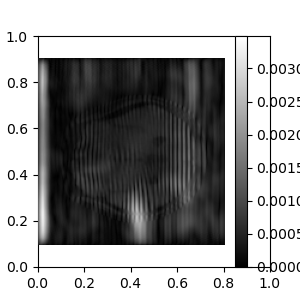

In [29]:
InteractiveFigure3D(
    torch.abs(images[...,0,0]).numpy(),
    vmin=0,
    vmax=images[...,0,0].abs().max(),
    cmap="gray",
).interactive